In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)
from sentence_transformers import SentenceTransformer

In [33]:
# Load dataset
dataset_path = r"C:\Users\KULKA\.cache\kagglehub\datasets\shivamb\real-or-fake-fake-jobposting-prediction\versions\1\fake_job_postings.csv"
df = pd.read_csv(dataset_path)
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
print("Dataset shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nFraudulent value counts:\n", df["fraudulent"].value_counts())


Dataset shape: (17880, 18)

Missing values per column:
 job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Fraudulent value counts:
 fraudulent
0    17014
1      866
Name: count, dtype: int64


C:\Users\KULKA\AppData\Local\Temp\ipykernel_10348\2238007768.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="fraudulent", palette="viridis")


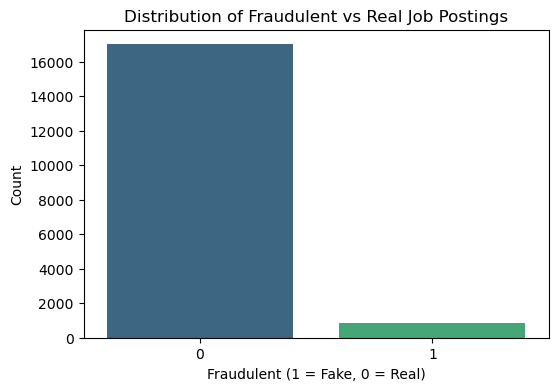

In [7]:
# ================================
# Visualization: Class Distribution
# ================================
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="fraudulent", palette="viridis")
plt.title("Distribution of Fraudulent vs Real Job Postings")
plt.xlabel("Fraudulent (1 = Fake, 0 = Real)")
plt.ylabel("Count")
plt.show()

NameError: name 'y_train' is not defined

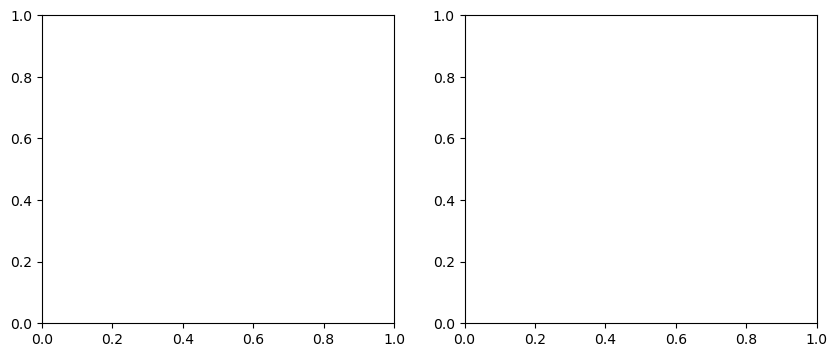

In [15]:
# Fill missing descriptions
X = df['description'].fillna("")
y = df['fraudulent']



In [19]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Encode text using BERT embeddings (if not done already)
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_emb = bert_model.encode(X_train.tolist(), batch_size=32, show_progress_bar=True)
X_test_emb = bert_model.encode(X_test.tolist(), batch_size=32, show_progress_bar=True)


Batches:   0%|          | 0/447 [00:00<?, ?it/s]

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_emb, y_train)


In [23]:
print("Balanced class counts:")
print(pd.Series(y_train_bal).value_counts())


Balanced class counts:
fraudulent
0    13611
1    13611
Name: count, dtype: int64


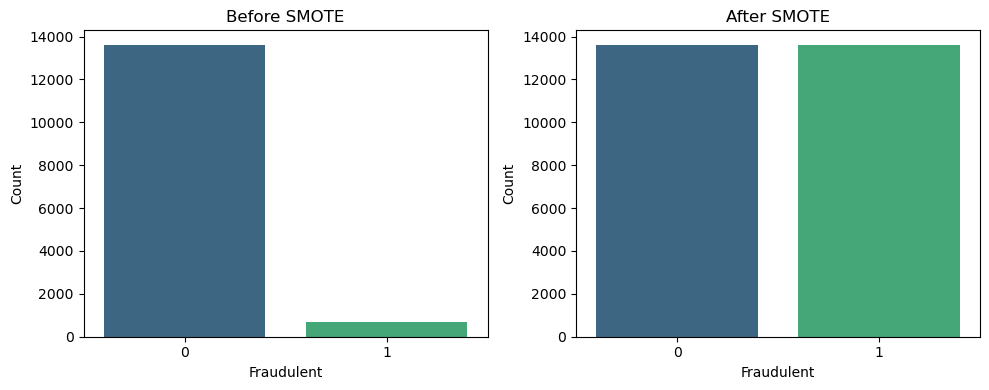

Before SMOTE: {0: 13611, 1: 693}
After SMOTE: {0: 13611, 1: 13611}


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=y_train, hue=y_train, ax=axes[0], palette="viridis", legend=False)
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Fraudulent")
axes[0].set_ylabel("Count")

sns.countplot(x=y_train_bal, hue=y_train_bal, ax=axes[1], palette="viridis", legend=False)
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Fraudulent")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_bal).value_counts().to_dict())


In [29]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

svm_clf = LinearSVC(C=0.5,max_iter=5000)
svm_clf.fit(X_train_bal, y_train_bal)

y_pred = svm_clf.predict(X_test_emb)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


C:\Users\KULKA\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.8769574944071589
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3403
           1       0.24      0.74      0.37       173

    accuracy                           0.88      3576
   macro avg       0.62      0.81      0.65      3576
weighted avg       0.95      0.88      0.90      3576



In [35]:
# joblib - python library to save models 
# models are saved to avoid retraining it again
# once this models are directly imported for using it in api
import joblib

# Save the trained model
joblib.dump(svm_clf, "svm_model.pkl")

# Load it later (without retraining)
svm_model = joblib.load("svm_model.pkl")
